# Harris Feature Detector



## Google Colab


In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/Colab Notebooks'

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import math
# import scipy.signal
# import scipy.linalg
# import importlib
# import mae6292.tools as mae6292

# from google.colab.patches import cv2_imshow
# from google.colab import files as FILE
# import os

## Jupyter Notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Harris Feature Detector

Consider [KITTI dataset](http://www.cvlibs.net/datasets/kitti/). We are going to perform feature extraction, description, and matching.

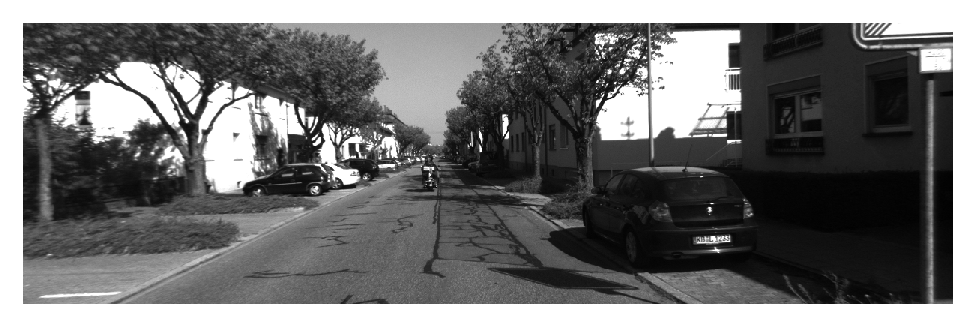

In [2]:
img = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

We will implement Harris detector for the above dataset. 

1. The image is convoluted with the Sobel filter to find the image gradient. As the image is relatively free of noise, there is no need to apply Gaussian smoothing. The Sobel filter can be separated into
\begin{align*}
S_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2\\ -1 & 0 & 1 \end{bmatrix} = \begin{bmatrix} 1 \\ 2 \\ 1\end{bmatrix} \begin{bmatrix} -1 & 0 & 1 \end{bmatrix} \triangleq S_1 S_2^T,\quad S_y = S_2S_1^T.
\end{align*}
It has been shown that the computational load for convolution with a [separable filter](https://en.wikipedia.org/wiki/Separable_filter) can be reduced. 

In python, it is implemented by [`scipy.signal.sepfir2d()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sepfir2d.html) with reflect padding:

```
scipy.signal.sepfir2d(img, filter_row, filter_col)
```
The computation time of `sepfir2d` is compared with
our implementation 

```
mae6292.convolve2d(img, filter, padding_type='zero')
```
and another 2d convolution `scipy.signal.convolve2d`
```
img_filtered_scipy = scipy.signal.convolve2d(img, filter, mode='same')
```


In [4]:
import time

S_1 = np.array([1, 2, 1], dtype='float32')
S_2 = np.array([-1, 0, 1], dtype='float32')
S_x = S_1.reshape(3,1)@S_2.reshape(1,3)
S_y = S_x.T

t = time.time()
I_x = scipy.signal.sepfir2d(img, S_2, S_1)
I_y = scipy.signal.sepfir2d(img, S_1, S_2)
print('sepfir2d',time.time()-t)

t = time.time()
I_xc = mae6292.convolve2d(img, S_x)
I_yc = mae6292.convolve2d(img, S_y)
print('mae6292',time.time()-t)

t = time.time()
I_xs = scipy.signal.convolve2d(img, S_x, mode='same')
I_ys = scipy.signal.convolve2d(img, S_y, mode='same')
print('convolve2d',time.time()-t)


sepfir2d 0.011139154434204102
mae6292 7.790491819381714
convolve2d 0.031163930892944336


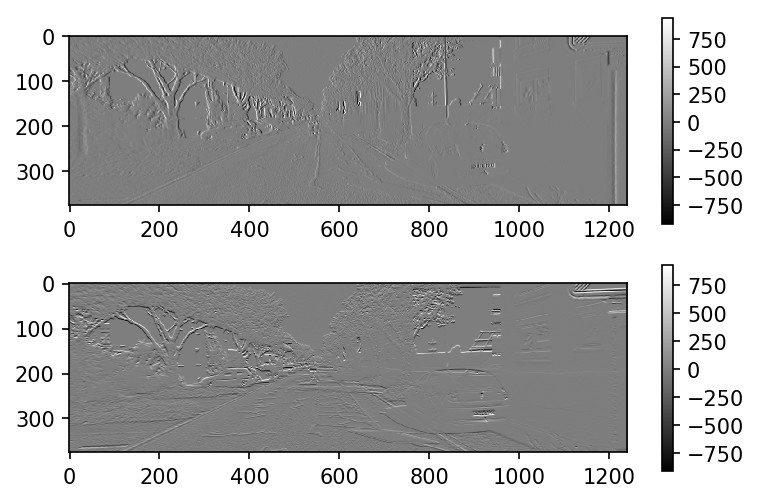

In [5]:
fig, ax = plt.subplots(2,1, dpi=150)
fig0 = ax[0].imshow(I_x,cmap='gray')
fig1 = ax[1].imshow(I_y,cmap='gray')
plt.colorbar(fig0,ax=ax[0])
plt.colorbar(fig1,ax=ax[1])

2. Compute the remaining $I_x^2, I_y^2, I_xI_y$ required for $M$ at every pixel.

In [7]:
I_x2 = I_x**2
I_y2 = I_y**2
I_xy = I_x*I_y

3. Let the size of the patch be $2W+1$. The matrix $M$ for Harris features at $(x,y)$ is 

\begin{align*}
M(x,y) = \sum_{-W \leq u,v\leq W} \begin{bmatrix} I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix}\bigg|_{x+u,y+v} 
\end{align*}

Instead of using double for loops for $u,v$ at every $(x,y)$, we compute each element of $M$ using convolution.

\begin{align*}
M_{x^2} = I_x^2 * \begin{bmatrix} 1 & 1& \cdots & 1 \\ \vdots & \vdots & &\vdots \\ 1 & 1& \cdots  & 1\end{bmatrix}
= I_x^2 * (\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1\end{bmatrix} \begin{bmatrix} 1 & 1 & \cdots & 1 \end{bmatrix}
\end{align*}

In [8]:
W_harris_patch = 2
filter_harris_sum = np.ones(2*W_harris_patch+1, dtype='float32')
M_x2 = scipy.signal.sepfir2d(I_x2, filter_harris_sum, filter_harris_sum)
M_y2 = scipy.signal.sepfir2d(I_y2, filter_harris_sum, filter_harris_sum)
M_xy = scipy.signal.sepfir2d(I_xy, filter_harris_sum, filter_harris_sum)

4. The resulting Harris score is
\begin{align*}
\text{Harris score} & = \mathrm{det}(M)-\kappa \mathrm{tr}(M)^2 \\
                    & = (M_{x^2}M_{y^2} - M_{xy}^2) - \kappa (M_{x^2}+M_{y^2})^2.
\end{align*}

Further, we wish to avoid any irregular behavior caused by the padding schemes utilized in convolution. Let the original image size be `width, height`. If the Sobel filter is applied without padding, the filterd image size will be `width-2, height-2`. Further, if the summation filter is applied without padding, the filtered image size will be `width-2-2*W, hegith-2-2*W`. As such, we set the edges of $M$ with the width $W+1$ zero.

Further, we set negative scores zero.

In [9]:
kappa = 0.08
harris_scores = (M_x2*M_y2 - M_xy**2) - kappa*(M_x2+M_y2)**2
harris_scores[0:W_harris_patch+1,:]=0
harris_scores[:,0:W_harris_patch+1]=0
harris_scores[:,-(W_harris_patch+1):]=0
harris_scores[-(W_harris_patch+1):,:]=0

with np.printoptions(precision=2):
    print(harris_scores[0:6,0:6])
    print('\n')
    print(harris_scores[-6:,-6:])

harris_scores[harris_scores<0]=0

[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.66e+09 1.50e+09 1.59e+09]
 [0.00e+00 0.00e+00 0.00e+00 2.59e+09 2.80e+09 3.35e+09]
 [0.00e+00 0.00e+00 0.00e+00 1.69e+09 1.70e+09 1.80e+09]]


[[-4.78e+09 -4.85e+09 -4.66e+09  0.00e+00  0.00e+00  0.00e+00]
 [-4.32e+09 -4.19e+09 -4.05e+09  0.00e+00  0.00e+00  0.00e+00]
 [-2.68e+09 -2.55e+09 -2.44e+09  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]]


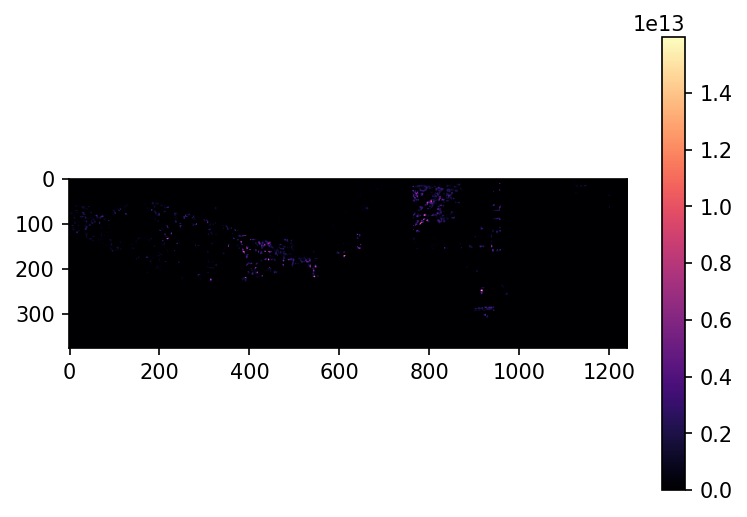

In [10]:
plt.figure(dpi=150)
plt.imshow(harris_scores, cmap='magma')
plt.colorbar()

This has been implemented by
```
harris_scores = mae6292.harris_corner(img, W_harris_patch, kappa_harris)
```

We can play with $W$ and $\kappa$ to study their effects on the harris score.

<ipython-input-18-86e0b9bee0ae>:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(harris_scores), cmap='magma')
<ipython-input-18-86e0b9bee0ae>:6: RuntimeWarning: overflow encountered in log
  plt.imshow(np.log(harris_scores), cmap='magma')


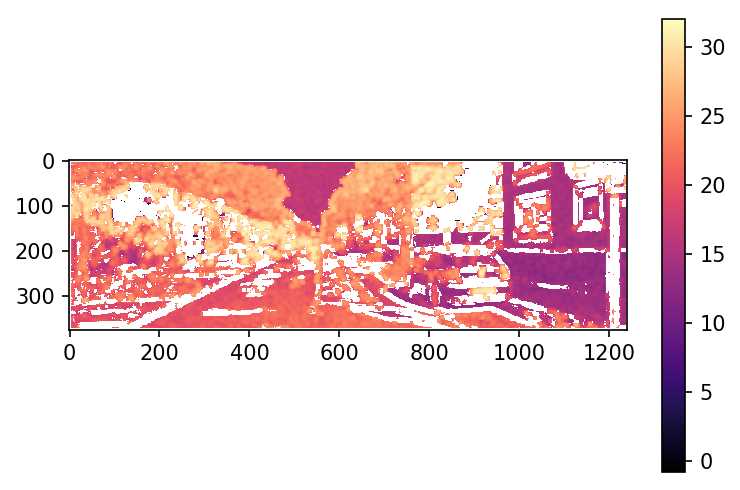

In [18]:
W_harris_patch, kappa_harris = 4, 0.08
harris_scores = mae6292.harris_corner(img, W_harris_patch, kappa_harris)

plt.figure(dpi=150)
# plt.imshow(harris_scores, cmap='magma')
plt.imshow(np.log(harris_scores), cmap='magma')
plt.colorbar()



## Select Keypoints

In class, the corner is defined as the pixel whose harris score is greater than a threshold. Two issues:
1. There is no guide on how to choose a proper threshold for varying images.
2. The number of resulting corners might be too large or too small. 

To avoid the above issues, we choose $N$ pixels with the highest scores. As illustrated above, pixles with high score tend to be grouped together. To prevent selecting neighboring pixels as keypoint, we perform **non-maximum suppression**, where for each keypoint selected, the pixel values within the box of $(2W+1)\times (2W+1)$ centered at the keypoint are set to zero.



In [19]:
W_harris_patch, kappa_harris = 4, 0.08
harris_scores = mae6292.harris_corner(img, W_harris_patch, kappa_harris)

N_keypoint, W_nms = 200, 8

n_rows, n_cols = img.shape
keypoints = []
for i in range(N_keypoint):
    u_max, v_max = np.unravel_index(harris_scores.argmax(), harris_scores.shape) # find the pixel of max score
    keypoints.append((u_max,v_max)) # add to keypoints
    
    # set the score within the surrounding box to zero
    harris_scores[ max(u_max-W_nms,0): min(u_max+W_nms+1,n_rows), max(v_max-W_nms,0): min(v_max+W_nms+1,n_cols)]=0
    
print(keypoints)

[(99, 783), (161, 388), (52, 805), (126, 643), (40, 768), (250, 916), (152, 643), (164, 445), (157, 398), (145, 443), (91, 792), (289, 940), (222, 390), (101, 283), (31, 771), (178, 444), (66, 781), (130, 383), (131, 217), (85, 258), (181, 532), (55, 796), (94, 823), (199, 445), (96, 305), (145, 424), (65, 821), (215, 542), (195, 535), (45, 826), (34, 816), (290, 928), (106, 768), (40, 843), (19, 766), (201, 544), (147, 433), (177, 489), (164, 436), (190, 401), (291, 906), (59, 944), (108, 218), (28, 846), (43, 809), (120, 226), (144, 383), (116, 774), (138, 403), (82, 792), (65, 799), (68, 953), (23, 818), (20, 795), (152, 356), (159, 943), (74, 822), (32, 785), (289, 919), (304, 925), (179, 435), (81, 811), (81, 776), (153, 472), (211, 420), (188, 496), (162, 418), (170, 610), (109, 349), (93, 832), (149, 936), (214, 429), (159, 954), (177, 498), (110, 38), (181, 523), (146, 242), (193, 477), (167, 461), (117, 371), (115, 954), (49, 768), (95, 86), (147, 371), (138, 482), (152, 831),

This has been implemented by 
```
mae6292.select_keypoints(score, N_keypoints, W_nms)
```
One can play with `N_keypoins` and `W_nms` to study their effects on the keypoints.

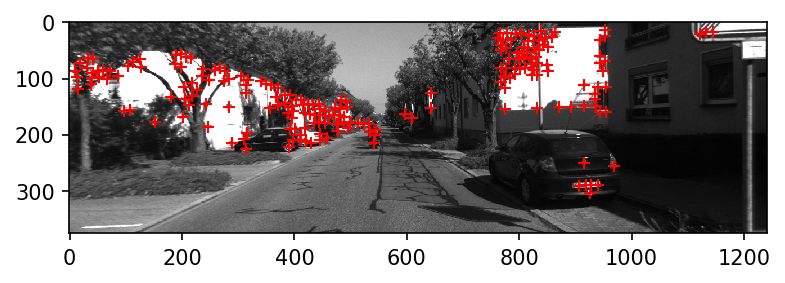

In [39]:
W_harris_patch, kappa_harris = 4, 0.08
harris_scores = mae6292.harris_corner(img, W_harris_patch, kappa_harris)
N_keypoint, W_nms = 200, 8
keypoints = mae6292.select_keypoints(harris_scores, N_keypoint, W_nms)

plt.figure(dpi=150)
plt.imshow(img, cmap='gray')
keypoints_uv = list(zip(*keypoints))
plt.plot(keypoints_uv[1],keypoints_uv[0],'r+')


## Describe Keypoints

We will study several feature descriptors to distinguish one keypoint from another keypoint. The simpliest way to describe a keypoint is extracting an image patch centered at the keypoint.

It is implemented by
```
mae6292.describe_keypoints(img, keypoints, W):
```
which returns a matrix of $(2W+1)^2\times \mathrm{len(keypoints)}$, whose $i$-th column corresponds to the vectorization of the image patch about the $i$-th keypoint.

In [40]:
W_descriptor = 9

descriptors = mae6292.describe_keypoints(img, keypoints, W_descriptor)

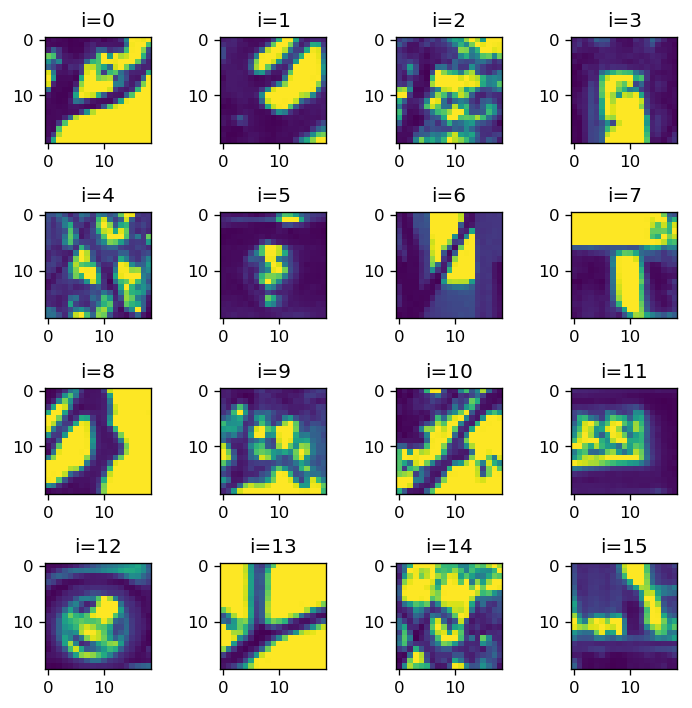

In [41]:
fig, axes = plt.subplots(4, 4, dpi=120, figsize=(6,6))
fig.tight_layout()
for i, a in enumerate(axes.ravel()):
    a.imshow(descriptors[:,i].reshape(2*W_descriptor+1,2*W_descriptor+1))
    a.set_title('i='+str(i))

## Match Keypoints

The above procedures for 

1. Harris corner detection
2. Keypoint selection
3. Keypoint description

can be repeated to the next image. 

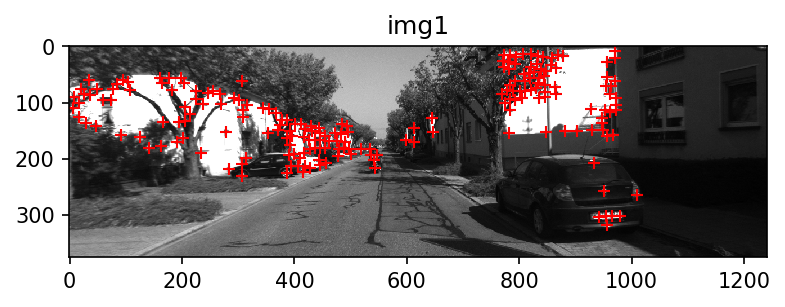

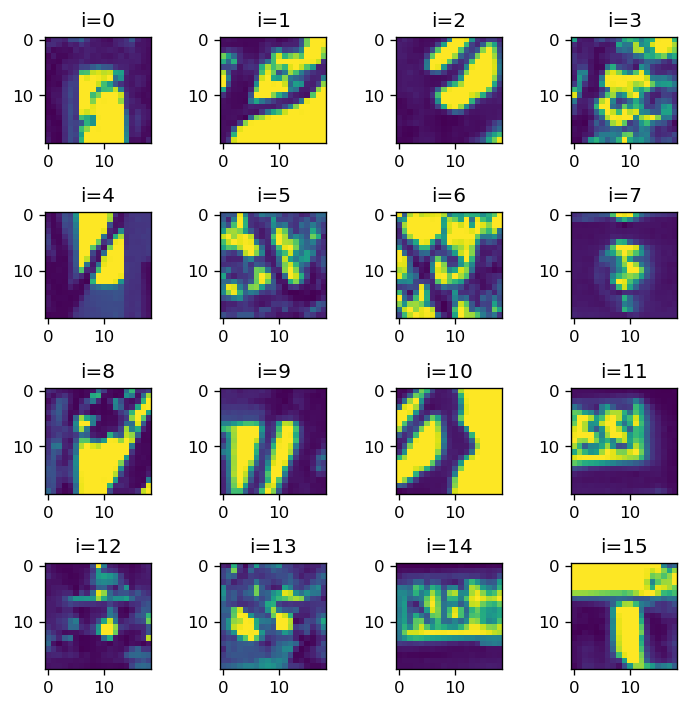

In [42]:
img1 = cv2.imread('data/000001.png',cv2.IMREAD_GRAYSCALE)

harris_score1 = mae6292.harris_corner(img1, W_harris_patch, kappa_harris)
keypoints1 = mae6292.select_keypoints(harris_score1, N_keypoint, W_nms)
descriptors1 = mae6292.describe_keypoints(img1, keypoints1, W_descriptor)

plt.figure(dpi=150)
plt.imshow(img1, cmap='gray')
plt.title('img1')
keypoints1_uv = list(zip(*keypoints1))
plt.plot(keypoints1_uv[1],keypoints1_uv[0],'r+')

fig, axes = plt.subplots(4, 4, dpi=120, figsize=(6,6))
fig.tight_layout()
for i, a in enumerate(axes.ravel()):
    a.imshow(descriptors1[:,i].reshape(2*W_descriptor+1,2*W_descriptor+1))
    a.set_title('i='+str(i))

How do we match descriptors?

1. The following command
```
scipy.spatial.distance.cdist(descriptors1.T, descriptors.T, 'euclidean')
```
returns a matrix, whose (i,j)-th element corresponds to the Euclidean distance between `descriptors1[:,i]` and `descriptors[:,j]`

2. For each `descriptors1[:,i]`, we find the index of the closest `descriptors`.

3. Then we declare it is a match if
```
distance < lambda_match * min_nonzero_distance
```
If there is no match, it is set to `-1`
4. Finally, we delete repeated matches. 


In [ ]:
# 1. compute pairwise distance
cdist = scipy.spatial.distance.cdist(descriptors1.T, descriptors.T, 'euclidean')

# 2. Find the closest descriptor and the distance
# descriptors1[:,i] is closest to descriptors[:,match[i]]
match = np.argmin(cdist, axis=1) 
# the corresopnding min distance between descriptors1[:,i] and descriptors[:,match[i]]
distance = cdist[np.arange(cdist.shape[0]),match]

# 3. Define match
# minimum nonzero distance
min_nonzero_distance = np.min(distance[np.nonzero(distance)])

lambda_match = 4
# if the distance is greater than the threshhold, then remove the match
match[distance >= lambda_match * min_nonzero_distance] = -1;

# 4 extract unique matches
_, unique_indices = np.unique(match, return_index=True)
unique_match = np.ones(match.shape,dtype='int64')*-1
unique_match[unique_indices] = match[unique_indices]

print(list(zip(range(12),unique_match[0:12])))

This has been implemented by
```
mae6292.match_descriptors(descriptors_new, descriptors_old, lambda_match)
```
We can play with `lambda_match` to understand its effects on the number of matched keypoints and the quality of matching.

number of matched discriptors =  48


(array([19., 22., 19., 30., 21., 20., 29., 30.,  8.,  2.]),
 array([ 134.2758355 ,  303.26543864,  472.25504178,  641.24464492,
         810.23424806,  979.2238512 , 1148.21345434, 1317.20305748,
        1486.19266062, 1655.18226376, 1824.1718669 ]),
 <a list of 10 Patch objects>)

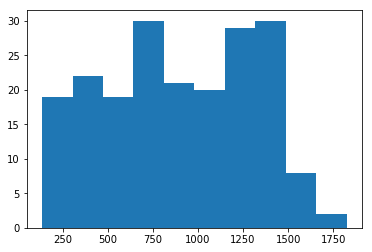

In [49]:
importlib.reload(mae6292)
lambda_match = 4 
match, distance = mae6292.match_descriptors(descriptors1, descriptors, lambda_match)

print('number of matched discriptors = ', (match>0).sum() )

plt.hist(distance)

## Visualize Matched Keypoints

The matched keypoints are visualized as follows.

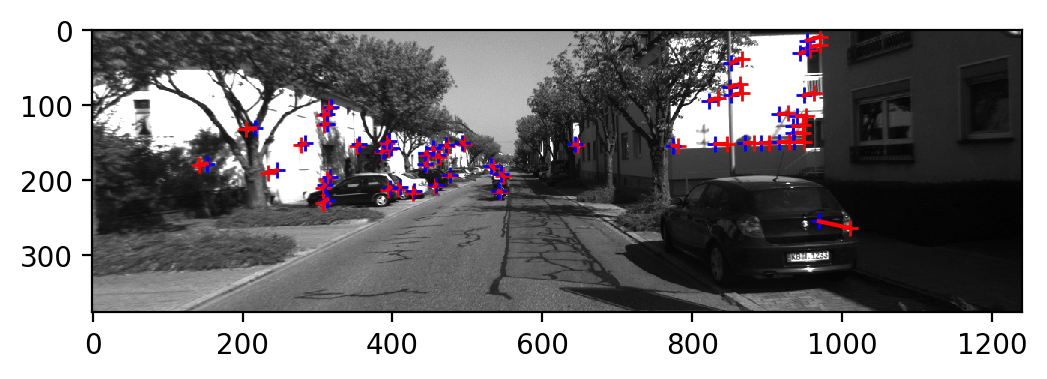

In [50]:
plt.figure(dpi=200)
plt.imshow(img1, cmap='gray')

for i in np.nditer(np.where(match>=0)): # iteration on matched keypoints
    u1, v1 = keypoints1[i] # matched keypoints on img1
    u, v = keypoints[match[i]] # matched keypoints on img
    
    plt.plot(v1, u1, 'r+') 
    plt.plot(v, u, 'b+')
    plt.plot([v,v1],[u,u1],'r')